In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
import numpy.ma as ma
import cartopy.crs as ccrs

import mplotutils as mpu
import cf_units
from tqdm import tqdm_notebook as tqdm

import glob


In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [71]:
##functions to calculate trends

def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(36),np.arange(72))
    slope=np.full([36,72],np.nan)
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        if not np.all(np.isnan(df[i_start:i_end+1,i_x,i_y])):
            #print(np.all(df[i_start:i_end+1,i_x,i_y]==np.nan),df[i_start:i_end+1,i_x,i_y])
            slope[i_x,i_y]=100*stats.linregress(np.arange(end-start+1)[~np.isnan(df[i_start:i_end+1,i_x,i_y])],
                                                df[i_start:i_end+1,i_x,i_y][~np.isnan(df[i_start:i_end+1,i_x,i_y])])[0]
    return slope

def mean_trend_from_dict(df,df_time,start,end, roll=False):
    
    print([df[key].shape for key in df.keys()])
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.mean(all_trends,axis=0),36,1)
    else:
        return np.mean(all_trends,axis=0)
    
def trend_dist_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.quantile(all_trends,[0.05,0.95],axis=0),36,1)
    else:
        return np.quantile(all_trends,[0.05,0.95],axis=0)
    
def trend_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(all_trends,36,1)
    else:
        return all_trends
        
            
def create_mask(df):
    
    ##First check that the year is 'valid' i.e. 5 months are non nana
    df=df.reshape(-1,12,df.shape[1],df.shape[2])
    valid_idx=np.zeros([df.shape[0],36,72])
    
    for yr_idx in range(df.shape[0]):
        valid_idx[yr_idx,:,:]=np.where(np.isnan(df[yr_idx,:,:,:]).sum(axis=0)>7,1,0)
        

    cutoff=valid_idx.shape[0]%5
            
    valid_idx=valid_idx[cutoff:,:,:].reshape(5,-1,36,72)
    
    mask_idx=np.zeros([5,36,72])
    
    for idx_block in range(5):
        mask_idx[idx_block,:,:]=np.where(valid_idx[idx_block,:,:,:].sum(axis=0)>np.floor(0.8*valid_idx.shape[1]),
                                                np.nan,1)
        
    print(valid_idx.shape,np.floor(0.8*valid_idx.shape[1]))
    mask_idx=np.prod(mask_idx,axis=0)
    
    return np.roll(~np.isnan(mask_idx),36,1)
        
    

In [ ]:
##read in observations
hadcrut_anom={}

dir_var_hn='/HadCRUT/v4.6.0.0/5deg_lat-lon_1m/original/'
obs_name_list=sorted(glob.glob(dir_var_hn+'HadCRUT.4.6.0.0.anomalies.*.nc'))

for i,obs_name in enumerate(obs_name_list): 
    data=xr.open_mfdataset(obs_name).groupby('time.year').mean('time').roll(longitude=180, roll_coords=True).sel(year=slice('1869-01-01', '2101-01-01'))
    hadcrut_anom[i]=data.temperature_anomaly.values
    

hadcrut_med=xr.open_mfdataset('/HadCRUT/v4.6.0.0/5deg_lat-lon_1m/original/HadCRUT.4.6.0.0.median.nc')
hadcrut_med=hadcrut_med.groupby('time.year').mean('time')#.sel(time=slice('1870-01-01', '2101-01-01'))

trend_2010_hadcrut_med={}
trend_2018_hadcrut_med={}

trend_2010_hadcrut={}
trend_2018_hadcrut={}



for ref in [1901,1951]:
    
    trend_2010_hadcrut_med[ref]=linregress_grid(hadcrut_med.sel(year=slice(1870,2021)).roll(longitude=180, roll_coords=True).temperature_anomaly.values,
                         hadcrut_med.sel(year=slice(1870,2021)).year.values,ref,2010)

    
    trend_2018_hadcrut_med[ref]=linregress_grid(hadcrut_med.sel(year=slice(1870,2021)).roll(longitude=180, roll_coords=True).temperature_anomaly.values,
                         hadcrut_med.sel(year=slice(1870,2021)).year.values,ref,2018)

    trend_2010_hadcrut[ref]=trend_dist_from_dict(hadcrut_anom,np.arange(1870,2021),ref,2010)
    trend_2018_hadcrut[ref]=trend_dist_from_dict(hadcrut_anom,np.arange(1870,2021),ref,2018)

(0.0, 1.0, 0.0, 1.0)

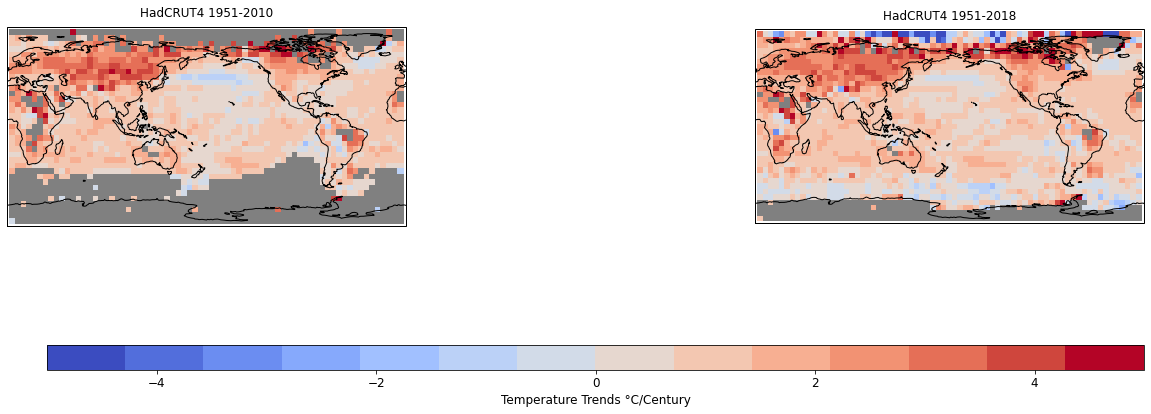

In [94]:
##Example plots of trends 

n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
lons=hadcrut_med.longitude.values
lats=hadcrut_med.latitude.values

i=0
for ref in [1951]:
    
    i_y=0

    ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=180))

    i_y+=1
    i+=1
    
    y_ma = np.zeros(mask_1951.shape)
    y_ma = ma.masked_array(y_ma, mask=mask_1951==False)
    y_ma[mask_1951]=trend_2010_hadcrut_med[ref][mask_1951]

    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, y_ma, transform=ccrs.PlateCarree(central_longitude=180), cmap=plt.cm.get_cmap('coolwarm',14),vmin=-5,vmax=5,rasterized=True)
    ax.set_title("HadCRUT4 %i-2010"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=180))
    i_y+=1
    
    i+=1
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, trend_2018_hadcrut_med[ref], transform=ccrs.PlateCarree(central_longitude=180), cmap=plt.cm.get_cmap('coolwarm',14),vmin=-5,vmax=5,rasterized=True)
    ax.set_title("HadCRUT4 %i-2018"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('Temperature Trends °C/Century')  
plt.axis('off')   

    
    


In [74]:
from loading import load_data_single_mod
import importlib
importlib.reload(sys.modules['loading'])
from loading import load_data_single_mod
import glob
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


gen=6
period=2018-1870

##create datasetsfor allforcing af, historical natural hn and preindustrial control piCONTROL
##models only usable if all-forcing run exists, at least 3 histNat runs exist and length of histNat is same as period under investigation

y_af={}
y_hn={}
y_pi={}

time={}

models=['MIROC6', 'IPSL-CM6A-LR', 'CanESM5', 'HadGEM3-GC31-LL', 'CNRM-CM6-1', 'GFDL-ESM4', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'NorESM2-LM', 'MRI-ESM2-0']

usable_models=[]
for model in models:
    
    scenario='historical'

    
    if gen==6:
        member = 'r*i1p1f*'
        hist_name = 'hist-nat'
    elif gen==5:
        hist_name = 'historicalNat'
        member = 'r*i1p1'
    
    len_hn=[]
    len_pi=[]
    
 
    y_af[model],time[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l=load_data_single_mod(gen,model,scenario,Tanglob_idx=False,Tref_all=True,Tref_start='1961-01-01',Tref_end='1991-01-01')
    len_af=[y_af[model][key].shape[0] for key in y_af[model].keys()]
    
        
    dir_var_hn='/net/so4/landclim/snath/DA/data/%s/regridded/'%model
    run_name_hn_list=sorted(glob.glob(dir_var_hn+'tas_ann_'+model+'_'+hist_name+'_'+member+'_g05.nc'))
    y_hn[model]={}
    for i,run_name_hn in enumerate(run_name_hn_list):
        
        data=xr.open_mfdataset(run_name_hn)
        data=data.sel(time=slice('1870-01-01', '2019-01-01')) ## select 1870 onwards (usually goes till 2018)
        y_hn[model][i]=data.tas.values
        len_hn.append(len(data.time.values)) 
        
    if len(len_af)<1 or len(len_hn)<3 or np.any(np.array(len_hn)<period+1):
        print('Cannot use model data for', model)
        print('AF run number, time length of: ', len(y_af[model].keys()), len_af)
        print('HN run number, time length of: ', len(run_name_hn_list), len_hn)
        continue
    else:
        usable_models.append(model)
                                      
    
        
    dir_var_pi='/net/so4/landclim/snath/DA/data/%s/regridded/'%model
    run_name_pi_list=sorted(glob.glob(dir_var_hn+'tas_ann_'+model+'_piControl_'+member+'_g05.nc'))
    y_pi[model]={}
    for i,run_name_pi in enumerate(run_name_pi_list): 
        data=xr.open_mfdataset(run_name_pi)
        y_pi[model][i]=data.tas.values
        len_pi.append(len(data.time.values)) 
        
    print('Got model data for', model)
    print('AF run number, time length of: ', len(y_af[model].keys()), len_af)
    print('HN run number, time length of: ', len(run_name_hn_list), len_hn)
    print('piControl run number, time length of: ', len(run_name_pi_list), len_pi)


start with model MIROC6
['/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r10i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r11i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r12i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r13i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r14i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r15i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r16i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r17i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r18i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/MIROC6/regridded/tas_ann_MIROC6_historical_r19i1p1f1_g05.nc', '/net/so4/landclim/snath/

Got model data for IPSL-CM6A-LR
AF run number, time length of:  32 [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
HN run number, time length of:  10 [149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
piControl run number, time length of:  1 [2000]
start with model CanESM5
['/net/so4/landclim/snath/DA/data/CanESM5/regridded/tas_ann_CanESM5_historical_r10i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/CanESM5/regridded/tas_ann_CanESM5_historical_r11i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/CanESM5/regridded/tas_ann_CanESM5_historical_r12i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/CanESM5/regridded/tas_ann_CanESM5_historical_r13i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/CanESM5/regridded/tas_ann_CanESM5_historical_r14i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/CanESM5/regridded/tas_ann_CanESM5_historical_r15i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/da

Got model data for ACCESS-ESM1-5
AF run number, time length of:  20 [149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149]
HN run number, time length of:  3 [149, 149, 149]
piControl run number, time length of:  1 [900]
start with model BCC-CSM2-MR
['/net/so4/landclim/snath/DA/data/BCC-CSM2-MR/regridded/tas_ann_BCC-CSM2-MR_historical_r1i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/BCC-CSM2-MR/regridded/tas_ann_BCC-CSM2-MR_historical_r2i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/BCC-CSM2-MR/regridded/tas_ann_BCC-CSM2-MR_historical_r3i1p1f1_g05.nc']
Got model data for BCC-CSM2-MR
AF run number, time length of:  3 [149, 149, 149]
HN run number, time length of:  3 [149, 149, 149]
piControl run number, time length of:  1 [600]
start with model NorESM2-LM
['/net/so4/landclim/snath/DA/data/NorESM2-LM/regridded/tas_ann_NorESM2-LM_historical_r1i1p1f1_g05.nc', '/net/so4/landclim/snath/DA/data/NorESM2-LM/regridded/tas_ann_NorESM2-LM_historical

In [100]:
models=usable_models
print(models)

['MIROC6', 'IPSL-CM6A-LR', 'CanESM5', 'HadGEM3-GC31-LL', 'CNRM-CM6-1', 'GFDL-ESM4', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'NorESM2-LM', 'MRI-ESM2-0']


In [75]:
from scipy.stats import linregress

## Drift correct the models preindustrial control runs
y_pi_dc={}

for model in models:
    
    if len(y_pi[model])>1:
        y_pi_temp=np.vstack(([y_pi[model][key] for key in y_pi[model].keys()]))
        y_pi_dc[model]=np.zeros_like(y_pi_temp)
    else:
        y_pi_dc[model]=np.zeros_like(y_pi[model][0])
        
    x,y=np.meshgrid(np.arange(y_pi[model][0].shape[1]),np.arange(y_pi[model][0].shape[2]))
    
    i_key=0
    for key in y_pi[model].keys():
        for i_x, i_y in zip(x.flatten(),y.flatten()):
            #print(i_x,i_y)
            slope, intercept,_,_,_=linregress(np.arange(y_pi[model][key].shape[0]),
                                              y_pi[model][key][:,i_x,i_y])
            drift=slope*np.arange(y_pi[model][key].shape[0])+intercept
            y_pi_dc[model][i_key:i_key+y_pi[model][key].shape[0],i_x,i_y]=y_pi[model][key][:,i_x,i_y]-drift
            
        i_key+=y_pi[model][key].shape[0]
        

In [149]:
def butter(df):
    
    output=np.zeros_like(df)
    for i_x,i_y in zip(x.flatten(),y.flatten()):
        output[:,i_x,i_y] = np.convolve(df[:,i_x,i_y].flatten(),np.ones(84)/84, mode='full')[:-83]#signal.filtfilt(b, a, df[:,i_x,i_y])
    
    output=output[84:,:,:]
    output=output[:-84,:,:]
    
    return output


In [150]:
## Calculate Internal Variability for observations
from scipy import signal

y_af_all=np.stack(([y_af[model][key] for model in  y_pi_dc.keys() for key in y_af[model]]))

hadcrut=xr.open_mfdataset('/net/exo/landclim/data/dataset/HadCRUT/v4.6.0.0/5deg_lat-lon_1m/original/HadCRUT.4.6.0.0.median.nc')#.resample(time='1M').mean()

##detrend observations assuming models have accurate trend
hadcrut_med_detrend=hadcrut.sel(time=slice('1944','2018')).roll(longitude=180, roll_coords=True).temperature_anomaly.values-np.mean(y_af_all,axis=0)

hadcrut_med_detrend=butter(hadcrut_med_detrend)

hadcrut_var=np.nanstd(hadcrut_med_detrend,axis=0)
nan_mask=~mask_1951 ##mask out values where observations are considered incomplete 
hadcrut_var[nan_mask]=np.nan 

    



(0.0, 1.0, 0.0, 1.0)

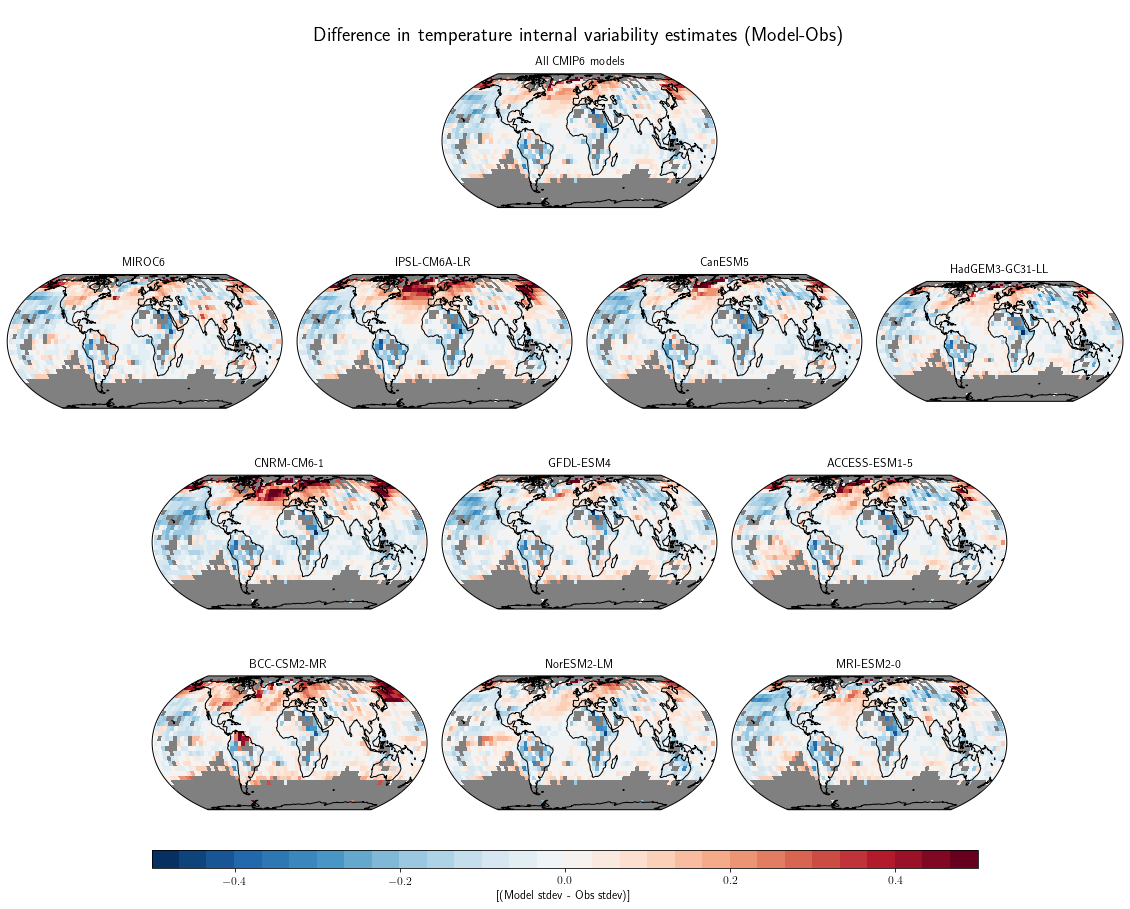

In [169]:
n_col = 4
n_row = 4

fig=plt.figure(figsize=(n_col*5, n_row * 4))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})
grid = plt.GridSpec(n_row*3+1, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

i=0
i_y=0

for i in range(len(models)+1):
    
    if i==0:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[model][key]),axis=0) for model in y_pi.keys() for key in y_pi[model].keys()])),axis=0)
        nan_mask=~mask_1951
        mod_pi_var[nan_mask]=np.nan 

        ax = plt.subplot(grid[i+1:i+3,(i_y+1)*10+5:(i_y+1)*10+15], projection=ccrs.EqualEarth())
        
    elif i<5:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]].keys()])),axis=0)
        nan_mask=~mask_1951
        mod_pi_var[nan_mask]=np.nan 
        
        ax = plt.subplot(grid[4:6,i_y*10:i_y*10+10], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
    
    elif i>4:
        mod_pi_var=np.mean(np.stack(([np.nanstd(butter(y_pi[models[i-1]][key]),axis=0) for key in y_pi[models[i-1]].keys()])),axis=0)
        nan_mask=~mask_1951
        mod_pi_var[nan_mask]=np.nan 
        if (i-5)%3==0:
            i_y=0
            ax = plt.subplot(grid[i+2:i+4,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))

        else:
            ax = plt.subplot(grid[(i-5)-((i-5)%3)+7:(i-5)-((i-5)%3)+9,i_y*10+5:i_y*10+15], projection=ccrs.EqualEarth(central_longitude=0))
        i_y+=1
        
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, (mod_pi_var-np.roll(hadcrut_var,36,axis=1)), transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r',30), vmin=-0.5, vmax=0.5, rasterized=True)
    if i==0:
        ax.set_title("All CMIP6 models",y=1.02,fontsize=12)
    else:
        ax.set_title(models[i-1],y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)

axtitle = plt.subplot(grid[0,6:-5])
plt.title('Difference in temperature internal variability estimates (Model-Obs)',fontsize=20, y=0.4)      
plt.axis('off') 

axcbar = plt.subplot(grid[-1:,5:-5])
cbar=plt.colorbar(mesh_1,orientation='horizontal',fraction=0.4,aspect=45)
cbar.set_label('[(Model stdev - Obs stdev)]')  
plt.axis('off') 


In [162]:
trend_2010_hn={}
trend_2018_hn={}

trend_2010_af={}
trend_2018_af={}

resampled_trend_hn_2010={}
resampled_trend_af_2010={}

resampled_trend_hn_2018={}
resampled_trend_af_2018={}

n_samples=50

y_af_all=np.stack(([y_af_mon[model][key] for model in  y_pi_dc.keys() for key in y_af_mon[model]]))

hadcrut=xr.open_mfdataset('/net/exo/landclim/data/dataset/HadCRUT/v4.6.0.0/5deg_lat-lon_1m/original/HadCRUT.4.6.0.0.median.nc')
hadcrut_med_detrend=hadcrut.sel(time=slice('1944','2018')).roll(longitude=180, roll_coords=True).temperature_anomaly.values-np.mean(y_af_all,axis=0)
#hadcrut_med_detrend=butter(hadcrut_med_detrend).reshape(-1,12,hadcrut_med_detrend.shape[1],hadcrut_med_detrend.shape[2]),axis=1)


obs_std=np.nanstd(butter(hadcrut_med_detrend),axis=0)


for model in models:
    
      
    mod_std=np.mean(np.stack(([np.nanstd(butter(y_pi_mon[model][key]),axis=0) for key in y_pi_mon[model].keys()])),axis=0)

    std_corr=obs_std/mod_std
    
    print('Creating trend distribution for', model)
    time[model]=np.arange(1870,2019)
    trend_2010_hn[model]={}
    trend_2018_hn[model]={}

    trend_2010_af[model]={}
    trend_2018_af[model]={}

    resampled_trend_hn_2010[model]={}
    resampled_trend_af_2010[model]={}

    resampled_trend_hn_2018[model]={}
    resampled_trend_af_2018[model]={}

    

    for ref in [1951]:


     
        trend_2010_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2010,roll=True)
        if model=='CESM2':
            trend_2018_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2014,roll=True)
        else:
            trend_2018_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2018,roll=True)#1870+y_hn[model][0].shape[0]-1

        trend_2010_af[model][ref]=mean_trend_from_dict(y_af[model],time[model],ref,2010,roll=True)
        trend_2018_af[model][ref]=mean_trend_from_dict(y_af[model],time[model],ref,2018,roll=True)

        #start resampling procedure for creation of distribution

        resampled_trend_hn_2010[model][ref]=np.zeros([n_samples,trend_2010_hn[model][ref].shape[0],
                                              trend_2010_hn[model][ref].shape[1]])
        resampled_trend_af_2010[model][ref]=np.zeros([n_samples,trend_2010_af[model][ref].shape[0],
                                              trend_2010_af[model][ref].shape[1]])


        resampled_trend_hn_2018[model][ref]=np.zeros([n_samples,trend_2018_hn[model][ref].shape[0],
                                              trend_2018_hn[model][ref].shape[1]])

        resampled_trend_af_2018[model][ref]=np.zeros([n_samples,trend_2018_af[model][ref].shape[0],
                                              trend_2018_af[model][ref].shape[1]])

   
        for sample in tqdm(range(n_samples)):

            start_pi=np.random.randint(0,y_pi_dc[model].shape[0]-(2010-ref))
            end_pi=start_pi+(2010-ref)

            resampled_trend_hn_2010[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2010_hn[model][ref]
            resampled_trend_af_2010[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2010_af[model][ref]
            resampled_trend_hn_2018[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2018_hn[model][ref]
            resampled_trend_af_2018[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)*std_corr)+trend_2018_af[model][ref]
            

Creating trend distribution for MIROC6
[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for IPSL-CM6A-LR
[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for CanESM5
[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for HadGEM3-GC31-LL
[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for CNRM-CM6-1
[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for GFDL-ESM4
[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for ACCESS-ESM1-5
[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for BCC-CSM2-MR
[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for NorESM2-LM
[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72)]


Creating trend distribution for MRI-ESM2-0
[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


[(149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72), (149, 36, 72)]


In [163]:
#creat array of trends containing all model values for starting time of interest

for ref in [1951]:
    
    resampled_trend_hn_2010[ref]=np.vstack(([resampled_trend_hn_2010[mod][ref] for mod in models]))
    resampled_trend_hn_2018[ref]=np.vstack(([resampled_trend_hn_2018[mod][ref] for mod in models]))
    
    resampled_trend_af_2010[ref]=np.vstack(([resampled_trend_af_2010[mod][ref] for mod in models]))
    resampled_trend_af_2018[ref]=np.vstack(([resampled_trend_af_2018[mod][ref] for mod in models]))

In [90]:
from scipy.stats import percentileofscore
import scipy
## need to find a more elegant method, this is quick and dirty

def attr_categorize(af_quantiles,hn_quantiles,obs_trend):
    
    try:
        sign=np.sign(obs_trend)

        #percentile_af=percentileofscore(af_quantiles,obs_trend)
        #percentile_hn=percentileofscore(hn_quantiles,obs_trend)

        loc_af,scale_af=scipy.stats.norm.fit(af_quantiles)
        loc_hn,scale_hn=scipy.stats.norm.fit(hn_quantiles)

        percentile_af=scipy.stats.norm.cdf(obs_trend,loc_af,scale_af)*100
        percentile_hn=scipy.stats.norm.cdf(obs_trend,loc_hn,scale_hn)*100

        if sign==1:
            if percentile_af>5 and percentile_af<95:
                if percentile_hn<=96:
                    return 0
                else:
                    return 2
            elif (percentile_hn<95 and percentile_hn>5):
                return 0
            elif (percentile_af<=5 and percentile_hn>=95):
                return 1
            elif percentile_af>=95:
                return 3
            elif percentile_hn<=5:
                return 0
        elif sign==-1:

            if (percentile_af<95 and percentile_af>5):
                if percentile_hn>=4:
                    return 0
                else:
                    return -2
            elif (percentile_hn>5 and percentile_hn<95):
                return 0
            elif (percentile_hn<=5 and percentile_af>=95):
                return -1
            elif percentile_af<=5:
                return -3
            if percentile_hn>=95:
                return 0
    except:
        return(np.nan)
        
        
        


    

In [166]:
## Assign attribution categories based on median values (deprecated)
ref=1951

attr_2010=np.full([36,72],np.nan)
attr_2018=np.full([36,72],np.nan)

x,y=np.meshgrid(np.arange(36),np.arange(72))

for i_x, i_y in zip(x.flatten(),y.flatten()):
    attr_2010[i_x,i_y]=attr_categorize(resampled_trend_af_2010[ref][:,i_x,i_y],
                                                         resampled_trend_hn_2010[ref][:,i_x,i_y],
                                            trend_2010_hadcrut_med[ref].reshape(1,36,72)[:,i_x,i_y])
    attr_2018[i_x,i_y]=attr_categorize(resampled_trend_af_2018[ref][:,i_x,i_y],
                                                         resampled_trend_hn_2018[ref][:,i_x,i_y],
                                            trend_2018_hadcrut_med[ref].reshape(1,36,72)[:,i_x,i_y])


(0.0, 1.0, 0.0, 1.0)

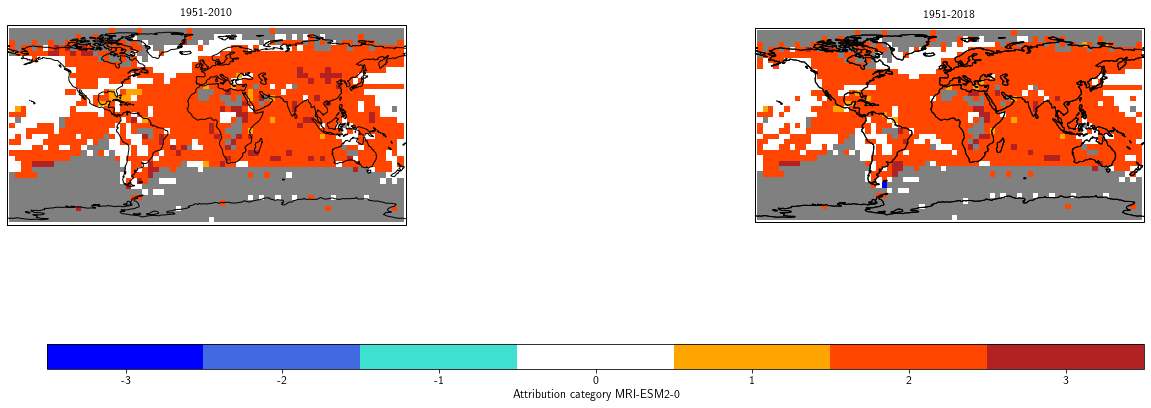

In [170]:
import matplotlib as mpl
n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['blue','royalblue', 'turquoise','white',
                                  'orange',"orangered",'firebrick'])

bounds = [ -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
i=0
for ref in [1951]:
    
    attr_2010[~mask_1951]=np.nan
    attr_2018[~mask_1951]=np.nan
    
    res_2010_plt=attr_2010
    
    res_2018_plt=attr_2018

    
    plt.title('Trend assessment using observation median values')
    i_y=0

    ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=0))
    
    ## make fake mesh so colorbar can be plotted without the extra grey bar
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, np.roll(res_2010_plt,-36,axis=1), transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,norm=norm,vmin=-4.5,rasterized=True)
    ax.set_title("%i-2010"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    i_y+=1
    i+=1

    ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree(central_longitude=0))

    i_y+=1
    i+=1
    ax.coastlines()
    
    res_2018_plt=attr_2018
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lons, lats, np.roll(res_2018_plt,-36,axis=1), transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap,norm=norm,vmin=-4.5,rasterized=True)
    ax.set_title("%i-2018"%(ref),y=1.02,fontsize=12)
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar=plt.colorbar(mesh_1,orientation='horizontal',ticks=[-3,-2,-1,0,1,2,3],fraction=0.4,aspect=45,extend='neither')
cbar.set_label('Attribution category %s'%model)
cbar.ax.set_xlim(-3.5,3.5)
cbar.ax.set_xticklabels(np.arange(-3,4))
plt.axis('off')   


In [171]:
## create dataset 

df_attr=xr.Dataset(
    {
        "Attribution_Category_2018": (["latitude", "longitude"], np.roll(attr_2018,-36,1)),## roll so not pacific centred
        "Attribution_Category_2010": (["latitude", "longitude"], np.roll(attr_2010,-36,1)), ## roll so not pacific centred

    },
    
    coords={
        "longitude": (["longitude"], lons),
        "latitude": (["latitude"], lats),
    },
)

df_attr.to_netcdf('tas_adj_attribution_categories_g05_centred_v1.nc')

# Plotting

In [106]:
## specify lon lat for the precip 2.5 grid
lon=np.array([-178.75, -176.25, -173.75, -171.25, -168.75, -166.25, -163.75,
       -161.25, -158.75, -156.25, -153.75, -151.25, -148.75, -146.25,
       -143.75, -141.25, -138.75, -136.25, -133.75, -131.25, -128.75,
       -126.25, -123.75, -121.25, -118.75, -116.25, -113.75, -111.25,
       -108.75, -106.25, -103.75, -101.25,  -98.75,  -96.25,  -93.75,
        -91.25,  -88.75,  -86.25,  -83.75,  -81.25,  -78.75,  -76.25,
        -73.75,  -71.25,  -68.75,  -66.25,  -63.75,  -61.25,  -58.75,
        -56.25,  -53.75,  -51.25,  -48.75,  -46.25,  -43.75,  -41.25,
        -38.75,  -36.25,  -33.75,  -31.25,  -28.75,  -26.25,  -23.75,
        -21.25,  -18.75,  -16.25,  -13.75,  -11.25,   -8.75,   -6.25,
         -3.75,   -1.25,    1.25,    3.75,    6.25,    8.75,   11.25,
         13.75,   16.25,   18.75,   21.25,   23.75,   26.25,   28.75,
         31.25,   33.75,   36.25,   38.75,   41.25,   43.75,   46.25,
         48.75,   51.25,   53.75,   56.25,   58.75,   61.25,   63.75,
         66.25,   68.75,   71.25,   73.75,   76.25,   78.75,   81.25,
         83.75,   86.25,   88.75,   91.25,   93.75,   96.25,   98.75,
        101.25,  103.75,  106.25,  108.75,  111.25,  113.75,  116.25,
        118.75,  121.25,  123.75,  126.25,  128.75,  131.25,  133.75,
        136.25,  138.75,  141.25,  143.75,  146.25,  148.75,  151.25,
        153.75,  156.25,  158.75,  161.25,  163.75,  166.25,  168.75,
        171.25,  173.75,  176.25,  178.75])
lat=np.array([-88.75, -86.25, -83.75, -81.25, -78.75, -76.25, -73.75, -71.25,
       -68.75, -66.25, -63.75, -61.25, -58.75, -56.25, -53.75, -51.25,
       -48.75, -46.25, -43.75, -41.25, -38.75, -36.25, -33.75, -31.25,
       -28.75, -26.25, -23.75, -21.25, -18.75, -16.25, -13.75, -11.25,
        -8.75,  -6.25,  -3.75,  -1.25,   1.25,   3.75,   6.25,   8.75,
        11.25,  13.75,  16.25,  18.75,  21.25,  23.75,  26.25,  28.75,
        31.25,  33.75,  36.25,  38.75,  41.25,  43.75,  46.25,  48.75,
        51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,  68.75,
        71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75])

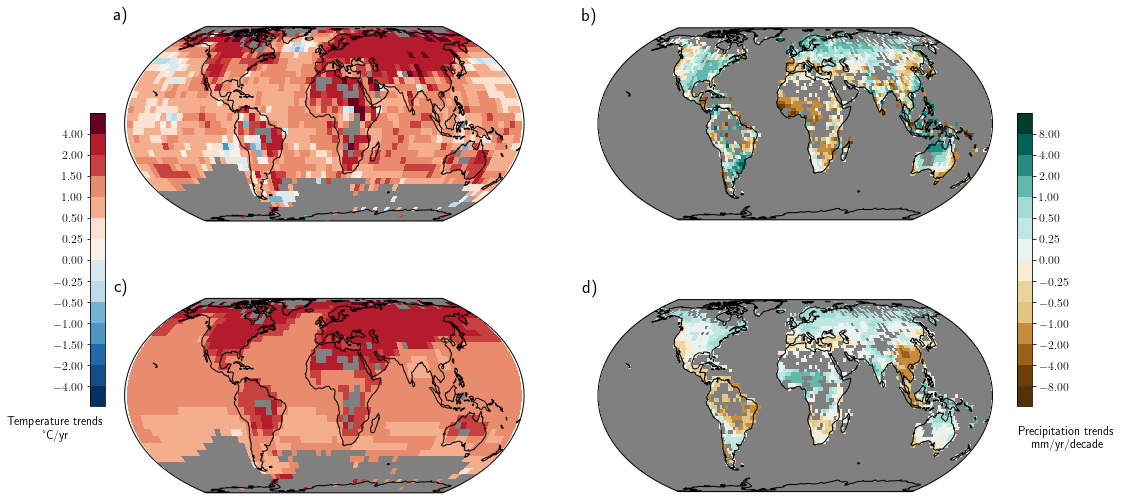

In [115]:
##load precip stuff
gpcc_trend=np.load('trend_1951_2016_gpcc.npy')
trend_af_precip=np.load('trend_1951_2016_af.npy')

fs_title=16

fig=plt.figure(figsize=(19,9))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

cmap = plt.cm.get_cmap('RdBu_r',20)

bounds = [ -5,-4,-2,-1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5,2,4,5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

grid = plt.GridSpec(2, 2, wspace=0.15, hspace=0.25) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

nan_mask = ~mask_1951+np.isnan(trend_2018_hadcrut_med[ref])
trend_2018_hadcrut_med[ref][nan_mask]=np.nan

ax_obs = plt.subplot(grid[0,0], projection=ccrs.EqualEarth())
ax_obs.coastlines()
mesh_1=ax_obs.pcolormesh(lons, lats, np.roll(trend_2018_hadcrut_med[ref],36,1), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, vmin=-5,vmax=5,rasterized=True)

cmap_mesh=mesh_1.get_cmap()
cmap_mesh.set_bad('gray')
mesh_1.set_cmap(cmap_mesh)
ax_obs.set_title('a)',fontsize=18, x=-0.01)



trend_af_plot = np.mean(resampled_trend_af_2018[ref],axis=0)
trend_af_plot[nan_mask] = np.nan

ax_mod = plt.subplot(grid[1,0], projection=ccrs.EqualEarth())
ax_mod.coastlines()
mesh_2=ax_mod.pcolormesh(lons, lats, np.roll(trend_af_plot,36,1), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,vmin=-5,vmax=5,rasterized=True)

cmap_mesh=mesh_2.get_cmap()
cmap_mesh.set_bad('gray')
mesh_2.set_cmap(cmap_mesh)

cbar=plt.colorbar(mesh_1, ax=[ax_obs,ax_mod], shrink=0.6,ticks=[-4,-2,-1.5, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 1.5,2,4],location='left',pad=0.04)
cbar.set_label('Temperature trends \n °C/yr', labelpad=-2, y=-0.12, rotation=0)
ax_mod.set_title('c)',fontsize=18, x=-0.01)
##do precip too

cmap = plt.cm.get_cmap('BrBG',24)

bounds = [ -9,-8,-4,-2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4, 8, 9]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax_obs = plt.subplot(grid[0,1], projection=ccrs.EqualEarth())
ax_obs.coastlines()
mesh_1=ax_obs.pcolormesh(lon, lat, gpcc_trend, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, vmin=-9,vmax=9,rasterized=True)

cmap_mesh=mesh_1.get_cmap()
cmap_mesh.set_bad('gray')
mesh_1.set_cmap(cmap_mesh)
ax_obs.set_title('b)',fontsize=18, x=-0.02)

nan_mask = np.isnan(gpcc_trend)
trend_af_precip[nan_mask] = np.nan

ax_mod = plt.subplot(grid[1,1], projection=ccrs.EqualEarth())
ax_mod.coastlines()
mesh_2=ax_mod.pcolormesh(lon, lat, trend_af_precip, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,vmin=-9,vmax=9,rasterized=True)

cmap_mesh=mesh_2.get_cmap()
cmap_mesh.set_bad('gray')
mesh_2.set_cmap(cmap_mesh)
ax_mod.set_title('d)',fontsize=18, x=-0.02)
cbar=plt.colorbar(mesh_1, ax=[ax_obs,ax_mod], shrink=0.6,ticks=[-8,-4,-2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4, 8])#,location='right')
cbar.set_label('Precipitation trends \n mm/yr/decade', labelpad=-2, y=-0.07, rotation=0)

plt.savefig('Model_Obs_Trends.pdf', transparent=True)


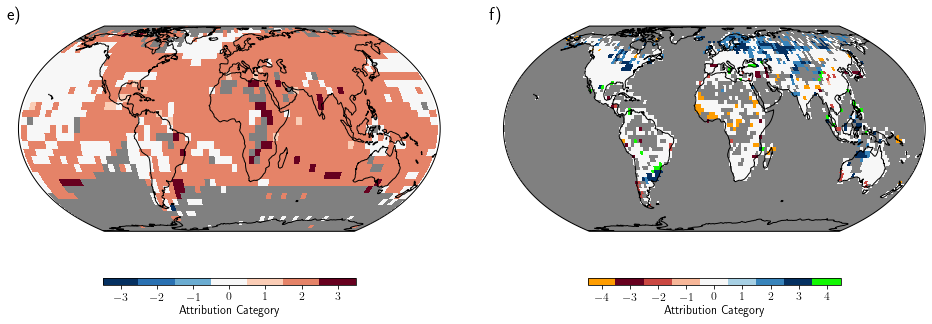

In [168]:
from sklearn.externals import joblib
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


fs_title=16

fig=plt.figure(figsize=(16.25,5.75))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

df_attr_precip=xr.open_dataset('precip_adj_attribution_categories_g05_centred_v2.nc')

grid = plt.GridSpec(1, 2, wspace=0.15, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = plt.cm.get_cmap('RdBu_r',9)

bounds = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


ax_attr_temp = plt.subplot(grid[0,0], projection=ccrs.EqualEarth())
ax_attr_temp.coastlines()
mesh_3=ax_attr_temp.pcolormesh(lons, lats, np.roll(res_2018_plt,-36,axis=1), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,rasterized=True)

cmap_mesh=mesh_3.get_cmap()
cmap_mesh.set_bad('gray')
mesh_3.set_cmap(cmap_mesh)
ax_attr_temp.set_title('e)',fontsize=18,x=-0.01)
plt.colorbar(mesh_3,ax=[ax_attr_temp],orientation='horizontal',ticks=[-3,-2,-1,0,1,2,3],shrink=0.6, label='Attribution Category',aspect=40)


cmap = plt.cm.get_cmap('RdBu',7)(np.linspace(0, 1, 7))
#cmap[-4:-1, :] = plt.cm.get_cmap('RdBu',6)(np.linspace(0, 1, 6))[-3:,:]
orange = np.array([255/256, 158/256, 1/256, 1])
#cmap[0, :] = orange
green = np.array([18/256, 248/256, 2/256, 1])
cmap = np.vstack((orange,cmap,green))
cmap = ListedColormap(cmap)

bounds = [-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

ax_attr_precip = plt.subplot(grid[0,1], projection=ccrs.EqualEarth())
ax_attr_precip.coastlines()
mesh_4=ax_attr_precip.pcolormesh(lon, lat, df_attr_precip.Attribution_Category_2016.values, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm,rasterized=True)

cmap_mesh=mesh_4.get_cmap()
cmap_mesh.set_bad('gray')
mesh_4.set_cmap(cmap_mesh)
ax_attr_precip.set_title('f)',fontsize=18,x=-0.02)
plt.colorbar(mesh_4,ax=[ax_attr_precip],orientation='horizontal',ticks=[-4,-3,-2,-1,0,1,2,3,4],shrink=0.6, label='Attribution Category',aspect=40)

plt.savefig('Model_Attr.pdf', transparent=True)
    